# Random Forest Classifier

In [1]:
import numpy as np

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import time

In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is /Users/lorenzobarbiero/Documents/GitHub/human_pose
data directory is /Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition


### Load the data

In [3]:
file_name = "movenet_thunder_mobilenet_large"

#choose from 
#'movenet_lightning_mobilenet_small'
#'movenet_lightning_mobilenet_large'
#'movenet_thunder_mobilenet_small'
#'movenet_thunder_mobilenet_large'

In [4]:
df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

# apply the function to the dataframe
df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
df['category'] = df['category'].apply(lambda x: np.array(x))

df['obj_input'] = df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())

df

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words,obj_input
0,Image_1.jpg,sitting,11,"[0.0882076621055603, 0.6247615814208984, 0.756...","[[0.60480165], [0.04718776], [0.032203343], [0...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo...","[-0.20592125285495, 0.3260203410991888, -0.008..."
1,Image_2.jpg,using_laptop,14,"[0.30178800225257874, 0.9912914037704468, 0.80...","[[0.7418762], [0.040941585], [0.012892539], [0...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ...","[0.2683790374652541, -0.6670002713657828, 0.87..."
2,Image_3.jpg,hugging,7,"[0.20708897709846497, 0.6019015908241272, 0.42...","[[0.1416007], [0.13604547], [0.05453948], [0.0...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape...","[-0.02030288063444885, 0.23200371996866265, 0...."
3,Image_4.jpg,sleeping,12,"[0.37268558144569397, 0.1374012678861618, 0.20...","[[0.6505104], [0.06191667], [0.027490702], [0....","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia...","[-0.8215984234954313, -0.02994576481942718, -0..."
4,Image_5.jpg,using_laptop,14,"[0.03276867792010307, 0.2222181260585785, 0.79...","[[0.71057284], [0.10088889], [0.035408325], [0...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto...","[-0.1494515264241883, -0.1284101833971808, -0...."
...,...,...,...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.04209192469716072, 0.7099579572677612, 0.58...","[[0.23895389], [0.14317973], [0.076097175], [0...","[706, 905, 624, 559, 831]","[[-0.399260014295578, 0.13120000064373016, -0....","[[patio], [window, shade], [library], [folding...","[-0.14739882579379793, 0.2794763101199509, -0...."
12596,Image_12597.jpg,clapping,1,"[0.06415694206953049, 0.705790638923645, 0.468...","[[0.8603377], [0.021510318], [0.016789775], [0...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w...","[0.057619909586660134, 0.26067134955875726, 0...."
12597,Image_12598.jpg,sitting,11,"[0.051420778036117554, 0.4904737174510956, 0.5...","[[0.48068434], [0.07919033], [0.043129846], [0...","[608, 743, 843, 487, 543]","[[-0.13323000073432922, -0.6275100111961365, -...","[[jean], [prison], [swing], [cellular, telepho...","[-0.001942008389194727, -0.2787240437545768, -..."
12598,Image_12599.jpg,dancing,3,"[0.2283279001712799, 0.42992380261421204, 0.62...","[[0.15199172], [0.068358354], [0.059058633], [...","[416, 615, 747, 617, 587]","[[0.5044400095939636, 0.536300003528595, -0.07...","[[balance, beam], [knee, pad], [punching, bag]...","[0.014005273690095521, 0.06621338508228547, -0..."


### Create Datasets

In [5]:
def train_test_split_df(df, test_perc): 
    
    n_classes = df['category'].nunique()
    
    n_samples = int(len(df)*test_perc/n_classes)
    
    test_df = df.groupby('category').apply(lambda x: x.sample(n_samples, random_state=420)).reset_index(drop=True)

    # split the dataframe in train and test by the column 'filename'

    train_df = df[~df['filename'].isin(test_df['filename'])]
    
    return train_df, test_df

In [6]:
train_df, test_df = train_test_split_df(df, 0.2)

In [7]:
def create_dataset(df, use_object=True, use_kpoints=True):
    
    if use_object and use_kpoints:
        df['input'] = df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)
        data = np.zeros((len(df), 17*3+100))
    
    elif use_kpoints:
        df['input'] = df['keypoints']
        data = np.zeros((len(df), 17*3))
        
    elif use_object:
        df['input'] = df['obj_input']
        data = np.zeros((len(df), 100))
    
    else:
        print('error - select at least one feature')
        return -1, -1
    
    for i, row in enumerate(df['input']): 
        data[i,:] = np.array(row)
        
    labels = df['category']

    return data, labels

### GridSearch
Commented by deafult, run at your own risk

In [8]:
'''
n_splits = 5

max_features = ['sqrt']
n_estimators = [150]
m_samples_s = [2]
m_samples_l = [1]

for mf in max_features:
    for nest in n_estimators:
        for ms in m_samples_s:
            for ml in m_samples_l:
                print("Fitting Random Forest")
                print("max_features", mf)
                print("n_estimators", nest)
                print('m_samples_s', ms)
                print('m_samples_l', ml)
                
                # KFold cross-validation
                kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

                accuracy_per_fold = []
                
                start = time.time()

                for train_index, val_index in kf.split(df):
            
                    df_train, df_val = df.iloc[train_index], df.iloc[val_index]
    
                    # Create dataset
                    train_dataset, train_labels = create_dataset(df_train)
                    val_dataset, val_labels = create_dataset(df_val)
    
                    # Create a new instance of the model
                    model = RandomForestClassifier(n_estimators=nest, 
                            min_samples_split=ms, 
                            min_samples_leaf=ml, 
                            max_features=mf, 
                            bootstrap=True, 
                            random_state=420, 
                            class_weight='balanced')

                    # Train the model
                    results = model.fit(train_dataset, train_labels)
    
                    # compute predicted labels
                    predicted_labels = model.predict(val_dataset)
    
                    # Evaluate the model
                    val_accuracy = accuracy_score(val_labels, predicted_labels)
                    accuracy_per_fold.append(val_accuracy)
                
                end = time.time()
                print('Training time:', round(end-start,2), "s")
                print("Average accuracy:", np.round(np.mean(accuracy_per_fold),3), "±", np.round(np.std(accuracy_per_fold),3))
                print("---------------------------------------------------------")
    
'''

'\nn_splits = 5\n\nmax_features = [\'sqrt\']\nn_estimators = [150]\nm_samples_s = [2]\nm_samples_l = [1]\n\nfor mf in max_features:\n    for nest in n_estimators:\n        for ms in m_samples_s:\n            for ml in m_samples_l:\n                print("Fitting Random Forest")\n                print("max_features", mf)\n                print("n_estimators", nest)\n                print(\'m_samples_s\', ms)\n                print(\'m_samples_l\', ml)\n                \n                # KFold cross-validation\n                kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)\n\n                accuracy_per_fold = []\n                \n                start = time.time()\n\n                for train_index, val_index in kf.split(df):\n            \n                    df_train, df_val = df.iloc[train_index], df.iloc[val_index]\n    \n                    # Create dataset\n                    train_dataset, train_labels = create_dataset(df_train)\n                    val_dataset

### Training on best model

In [9]:
# Number of folds
n_splits = 5

index = 1

# KFold cross-validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_per_fold = []
conf_matrix = np.zeros((15,15))


for train_index, val_index in kf.split(df, df['category']):
    
    print("Starting Fold Number", index)
    print()
    
    index += 1
    
    df_train, df_val = df.iloc[train_index], df.iloc[val_index]
    
    # Convert to TensorFlow datasets
    train_dataset, train_labels = create_dataset(df_train)
    val_dataset, val_labels = create_dataset(df_val)
    
    print("Fitting the model:")
    
    start = time.time()
    
    # Create a new instance of the model
    model = RandomForestClassifier(n_estimators=150, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            max_features='sqrt', 
                            bootstrap=True, 
                            random_state=420, 
                            class_weight='balanced')

    # Train the model
    results = model.fit(train_dataset, train_labels)

    end = time.time()
    print('Training time:', round(end-start,2), "s")
    
    # compute predicted labels
    predicted_labels = model.predict(val_dataset)
    
    # compute the confusion matrix
    cm = confusion_matrix(val_labels, predicted_labels)
    #print(cm)
    conf_matrix = conf_matrix + cm
    
    # Evaluate the model
    val_accuracy = accuracy_score(val_labels, predicted_labels)
    print("Accuracy:", round(val_accuracy,3))
    accuracy_per_fold.append(val_accuracy)
    
    print()
    print('-----------------------------------------------------------------')
    print()

Starting Fold Number 1

Fitting the model:
Training time: 17.22 s
Accuracy: 0.562

-----------------------------------------------------------------

Starting Fold Number 2

Fitting the model:
Training time: 17.58 s
Accuracy: 0.542

-----------------------------------------------------------------

Starting Fold Number 3

Fitting the model:
Training time: 17.8 s
Accuracy: 0.546

-----------------------------------------------------------------

Starting Fold Number 4

Fitting the model:
Training time: 18.43 s
Accuracy: 0.562

-----------------------------------------------------------------

Starting Fold Number 5

Fitting the model:
Training time: 19.23 s
Accuracy: 0.537

-----------------------------------------------------------------



### Plot The Results

In [10]:
# get the label from the category
labels = df.groupby('category').first()['label']
labels = np.array(labels).tolist()
labels[9] = 'music'

In [11]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, threshold=0.1, val=True):
    #normalize cm
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(11, 6))
    if val:
        ax = sns.heatmap(cm_normalized, annot=False, cmap='Greens', vmin=0, vmax=1, cbar=True, xticklabels=labels, yticklabels=labels)
        ax.set_title("SVM - Validation Set")
    else:
        ax = sns.heatmap(cm_normalized, annot=False, cmap='Oranges', vmin=0, vmax=1, cbar=True, xticklabels=labels, yticklabels=labels)
        ax.set_title("SVM - Test Set")
    
    # Annotate only the main diagonal with rounded values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j or cm_normalized[i, j] > threshold:
                if cm_normalized[i, j] < 0.7:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='black', fontsize=14)
                else:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='white', fontsize=14)    
                
    # Labels, title and axes
    ax.set_xlabel('Predicted labels', fontsize = 14)
    ax.set_ylabel('True labels', fontsize = 14)
    plt.xticks(rotation=60)
    
    plt.show()

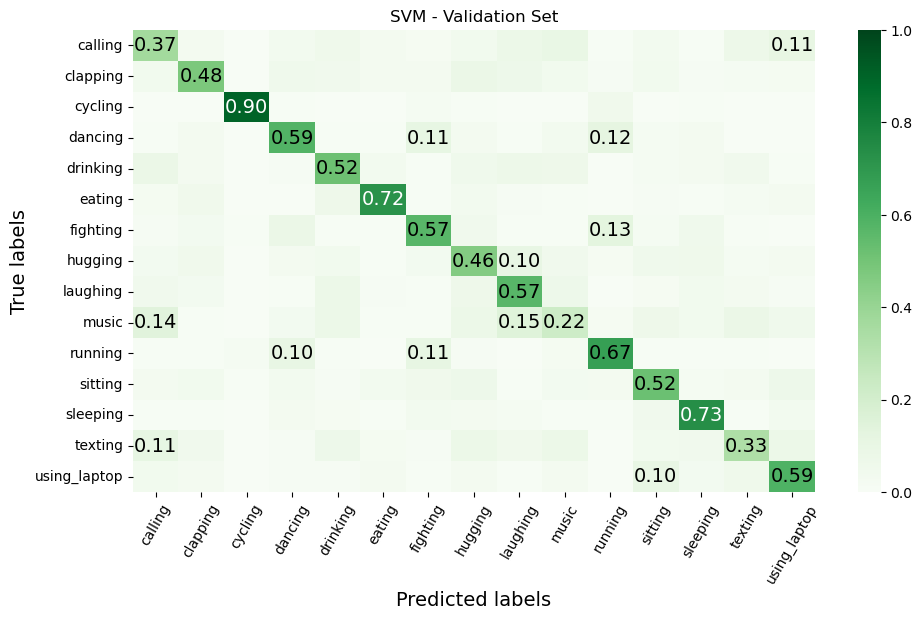

In [12]:
plot_confusion_matrix(conf_matrix)

In [13]:
def class_specific_metrics(cm, class_labels = labels):

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

In [14]:
val_metrics = class_specific_metrics(conf_matrix)
val_metrics

,Accuracy,Sensitivity,Specificity,Precision
calling,0.917698,0.367857,0.956973,0.379141
clapping,0.937937,0.478571,0.970748,0.538874
cycling,0.989762,0.900000,0.996173,0.943820
dancing,0.941270,0.585714,0.966667,0.556561
drinking,0.933889,0.519048,0.963520,0.504046
eating,0.965794,0.721429,0.983248,0.754670
fighting,0.940556,0.566667,0.967262,0.552846
hugging,0.919127,0.457143,0.952126,0.405491
laughing,0.931270,0.570238,0.957058,0.486789
music,0.911429,0.223810,0.960544,0.288344


### Test set

In [16]:
train_dataset, train_labels = create_dataset(train_df)

# Create a new instance of the model
model = RandomForestClassifier(n_estimators=150, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            max_features='sqrt', 
                            bootstrap=True, 
                            random_state=420, 
                            class_weight='balanced')

# Train the model
results = model.fit(train_dataset, train_labels)

In [17]:
test_dataset, test_labels = create_dataset(test_df)

In [18]:
# compute predicted labels
predicted_labels = model.predict(test_dataset)
    
# compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
    
# Evaluate the model
val_accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", round(val_accuracy,3))

Accuracy: 0.544


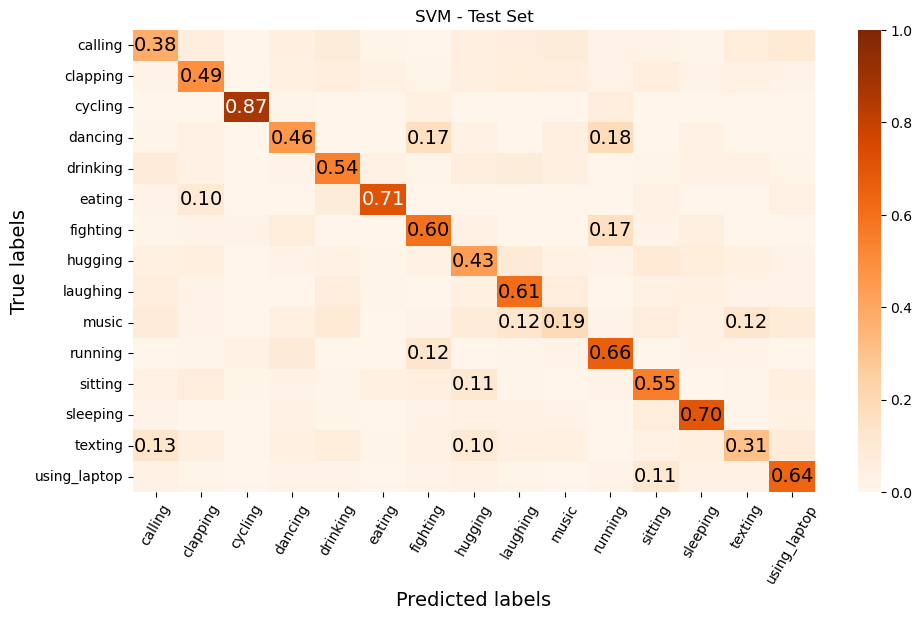

In [19]:
plot_confusion_matrix(cm, val=False)

In [20]:
test_metrics = class_specific_metrics(cm)
test_metrics

,Accuracy,Sensitivity,Specificity,Precision
calling,0.921825,0.380952,0.960459,0.407643
clapping,0.933333,0.494048,0.964711,0.500000
cycling,0.985317,0.869048,0.993622,0.906832
dancing,0.932937,0.464286,0.966412,0.496815
drinking,0.933730,0.541667,0.961735,0.502762
eating,0.969841,0.714286,0.988095,0.810811
fighting,0.937698,0.595238,0.962160,0.529101
hugging,0.919841,0.434524,0.954507,0.405556
laughing,0.937302,0.613095,0.960459,0.525510
music,0.917857,0.190476,0.969813,0.310680


### Test on other APIs

In [21]:
# helper function

def fitRF(file_name, use_kpoints=True, use_object=True):
    
    df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

    # apply the function to the dataframe
    df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
    df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
    df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
    df['category'] = df['category'].apply(lambda x: np.array(x))
    df['obj_input'] = df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
    df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())
    
    print('Loaded dataset ', file_name)
    
    train_df, test_df = train_test_split_df(df, 0.2)

    train_dataset, train_labels = create_dataset(train_df, use_kpoints=use_kpoints, use_object=use_object)
    test_dataset, test_labels = create_dataset(test_df, use_kpoints=use_kpoints, use_object=use_object)

    # Create a new instance of the model
    model = RandomForestClassifier(n_estimators=150, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            max_features='sqrt', 
                            bootstrap=True, 
                            random_state=420, 
                            class_weight='balanced')
    # Train the model
    results = model.fit(train_dataset, train_labels)
    
    # compute predicted labels
    predicted_labels = model.predict(test_dataset)
    
    # compute the confusion matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    
    # Evaluate the model
    val_accuracy = accuracy_score(test_labels, predicted_labels)
    print("Accuracy:", round(val_accuracy,3))
    
    plot_confusion_matrix(cm, val=False)
    
    test_metrics = class_specific_metrics(cm)
    print(test_metrics)

Loaded dataset  movenet_lightning_mobilenet_small
Accuracy: 0.506


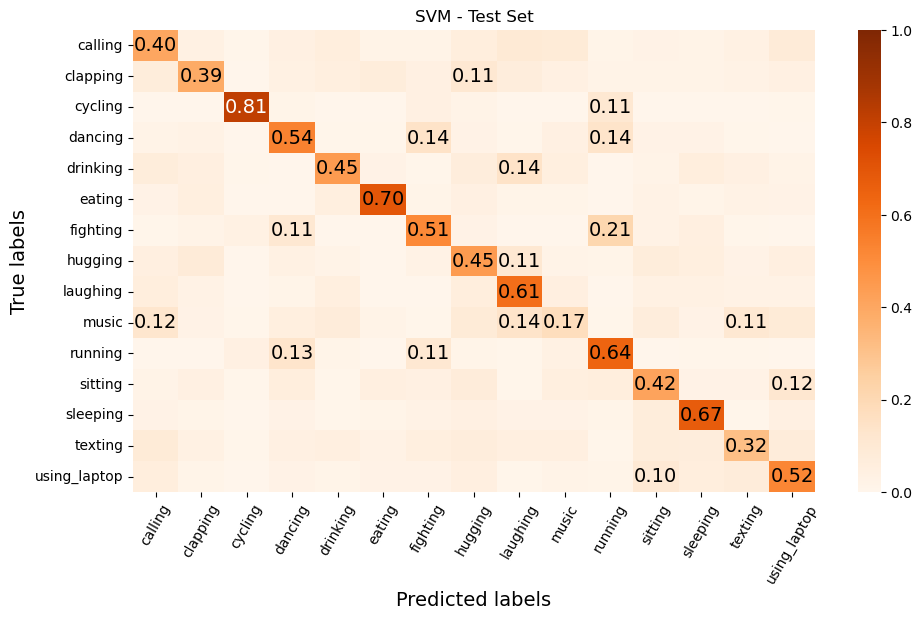

              Accuracy  Sensitivity  Specificity  Precision
calling       0.919444     0.404762     0.956207   0.397661
clapping      0.930952     0.386905     0.969813   0.477941
cycling       0.980159     0.809524     0.992347   0.883117
dancing       0.930556     0.535714     0.958759   0.481283
drinking      0.936111     0.446429     0.971088   0.524476
eating        0.963095     0.696429     0.982143   0.735849
fighting      0.930556     0.511905     0.960459   0.480447
hugging       0.914286     0.446429     0.947704   0.378788
laughing      0.929762     0.607143     0.952806   0.478873
music         0.912698     0.172619     0.965561   0.263636
running       0.936111     0.642857     0.957058   0.516746
sitting       0.923810     0.416667     0.960034   0.426829
sleeping      0.948413     0.672619     0.968112   0.601064
texting       0.926190     0.315476     0.969813   0.427419
using_laptop  0.929762     0.523810     0.958759   0.475676


In [22]:
fitRF('movenet_lightning_mobilenet_small')

Loaded dataset  movenet_lightning_mobilenet_large
Accuracy: 0.53


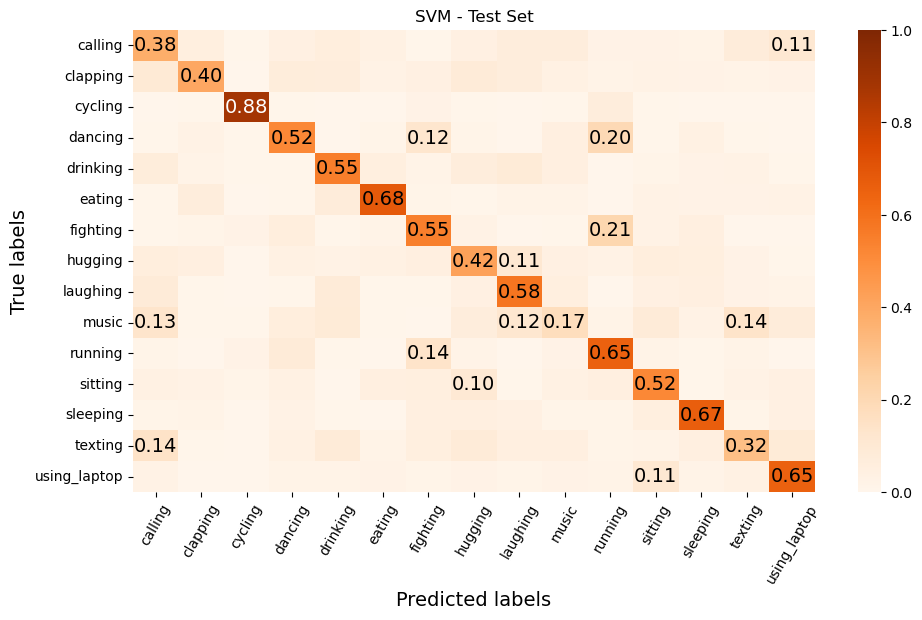

              Accuracy  Sensitivity  Specificity  Precision
calling       0.912302     0.375000     0.950680   0.351955
clapping      0.940079     0.398810     0.978741   0.572650
cycling       0.986508     0.880952     0.994048   0.913580
dancing       0.934921     0.517857     0.964711   0.511765
drinking      0.935317     0.553571     0.962585   0.513812
eating        0.959921     0.684524     0.979592   0.705521
fighting      0.930952     0.547619     0.958333   0.484211
hugging       0.919841     0.422619     0.955357   0.403409
laughing      0.934127     0.583333     0.959184   0.505155
music         0.913889     0.172619     0.966837   0.271028
running       0.933333     0.654762     0.953231   0.500000
sitting       0.932937     0.517857     0.962585   0.497143
sleeping      0.952381     0.666667     0.972789   0.636364
texting       0.925397     0.315476     0.968963   0.420635
using_laptop  0.947619     0.654762     0.968537   0.597826


In [23]:
fitRF('movenet_lightning_mobilenet_large')

Loaded dataset  movenet_thunder_mobilenet_small
Accuracy: 0.519


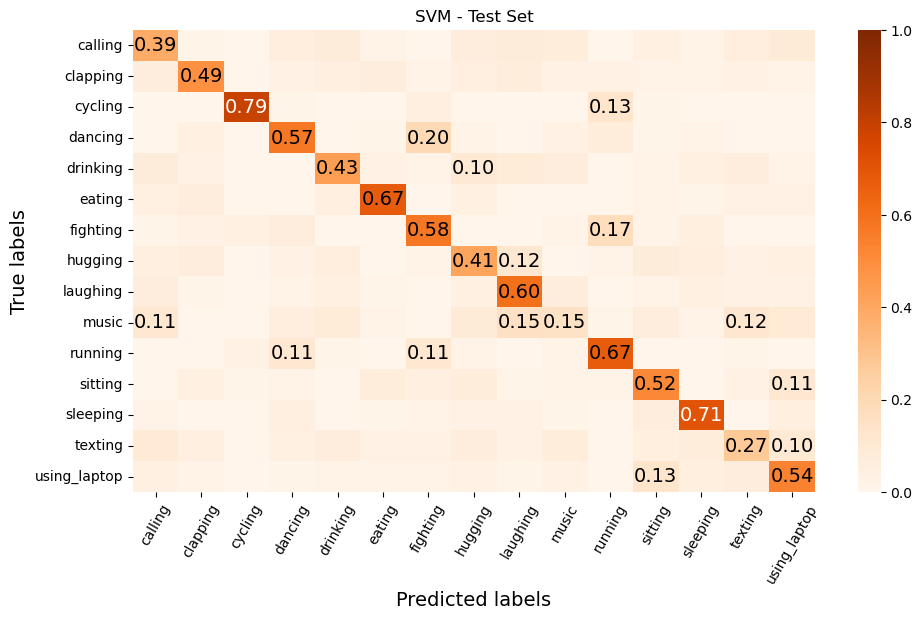

              Accuracy  Sensitivity  Specificity  Precision
calling       0.919841     0.386905     0.957908   0.396341
clapping      0.940873     0.488095     0.973214   0.565517
cycling       0.978571     0.791667     0.991922   0.875000
dancing       0.936111     0.571429     0.962160   0.518919
drinking      0.931349     0.434524     0.966837   0.483444
eating        0.957143     0.672619     0.977466   0.680723
fighting      0.935714     0.577381     0.961310   0.515957
hugging       0.918254     0.410714     0.954507   0.392045
laughing      0.932937     0.601190     0.956633   0.497537
music         0.911905     0.148810     0.966412   0.240385
running       0.946429     0.672619     0.965986   0.585492
sitting       0.930159     0.517857     0.959609   0.478022
sleeping      0.951984     0.708333     0.969388   0.623037
texting       0.918651     0.273810     0.964711   0.356589
using_laptop  0.928968     0.535714     0.957058   0.471204


In [24]:
fitRF('movenet_thunder_mobilenet_small')

Loaded dataset  movenet_thunder_mobilenet_large
Accuracy: 0.544


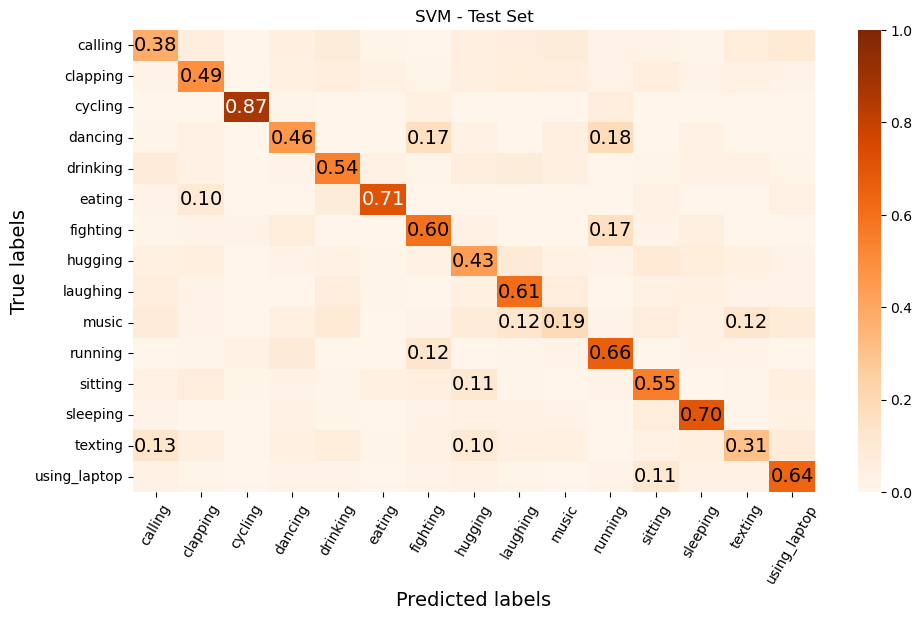

              Accuracy  Sensitivity  Specificity  Precision
calling       0.921825     0.380952     0.960459   0.407643
clapping      0.933333     0.494048     0.964711   0.500000
cycling       0.985317     0.869048     0.993622   0.906832
dancing       0.932937     0.464286     0.966412   0.496815
drinking      0.933730     0.541667     0.961735   0.502762
eating        0.969841     0.714286     0.988095   0.810811
fighting      0.937698     0.595238     0.962160   0.529101
hugging       0.919841     0.434524     0.954507   0.405556
laughing      0.937302     0.613095     0.960459   0.525510
music         0.917857     0.190476     0.969813   0.310680
running       0.940873     0.660714     0.960884   0.546798
sitting       0.932143     0.553571     0.959184   0.492063
sleeping      0.953968     0.696429     0.972364   0.642857
texting       0.926190     0.309524     0.970238   0.426230
using_laptop  0.945238     0.642857     0.966837   0.580645


In [25]:
fitRF('movenet_thunder_mobilenet_large')